In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from musicautobot.imports import *
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.vocab import *

# Do this instead
from musicautobot.music_transformer.all import *
from musicautobot.multitask_transformer.all import *

In [3]:
from fastai.text.all import *

In [4]:
torch.cuda.set_device(5)

## MultitaskTransformer Training

**NOTE** 
This notebook assumes you've already preprocessed `reddit_musicitem_data_save.pkl`.  
If you haven't, run `musicautobot/notebook/music_transformer/DataPreprocessing-Reddit.ipynb` first.

## End to end training pipeline 

1. Create and encode dataset
2. Initialize Transformer MOdel
3. Train
4. Predict

In [5]:
base_path = Path('../data/soundpack_midi')

# Location of your midi files
midi_path = base_path/'midi_sources/hooktheory'

# Location to save dataset
s2s_path = base_path/'s2s_encode/hooktheory'
lm_path = base_path/'piano_duet/hooktheory'

[p.mkdir(parents=True, exist_ok=True) for p in [midi_path, s2s_path, lm_path]];

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [6]:
min_variation = 3 # minimum number of different midi notes played

In [7]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

2057

In [8]:
# vocab = MusicVocab.create()

# item = MusicItem.from_file(midi_files[0], vocab)

# mti = MultitrackItem.from_file(midi_files[0], vocab)

## Playground

### TODO: 
### USE PIPELINE TO DO TRANSFORMATION
### USE fastai core @patch to make these functions part of music21 library

In [9]:
# input_path = midi_files[0]

# stream = file2stream(input_path)

# ## Should we filter out pitches outside of max keyboard notes here?

# pitches = stream.parts[0].pitches
# p = pitches[0]
# p.midi

# len(list(stream.parts[1].getElementsByClass('Chord')))

# ## Should we set max duration of notes here?

# notes = stream.parts[0].notes
# n = notes[0]
# n.beatDuration.quarterLength = 8

# stream.remove([p for p in stream.parts if not is_valid_part(p)])

## Transform MIDI

In [10]:
vocab = MusicVocab.create()

In [11]:
def process_metadata(midi_file, base_path=s2s_path, item_cls=MultitrackItem):
    # Get outfile and check if it exists
    out_file = base_path/midi_file.relative_to(midi_path).with_suffix('.npy')
    out_file.parent.mkdir(parents=True, exist_ok=True)
    if out_file.exists(): return
    
    item = item_cls.from_file(midi_file, vocab)
    if item is not None: item.save(out_file)

In [12]:
# # sanity check
import random
# for mf in random.sample(midi_files, 10):
for mf in midi_files:
    print(mf)
    process_metadata(mf)
    process_metadata(mf, base_path=lm_path, item_cls=MusicItem)

../data/soundpack_midi/midi_sources/hooktheory/billboard/Jess Glynne - Hold My Hand - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Colbie Caillat - Brighter Than The Sun - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Shakira - La Tortura Ft Alejandro Sanz - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Walk The Moon - Shut Up And Dance - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lorde - Team - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Weeknd - The Hills - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Phoenix - 1901 - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Ciara - Oh - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Shins - Phantom Limb - verse_key_cmajor.mid
../data/soundpack_midi/midi_s

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem - Headlights   Ft Nate Ruess - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - Alright - pre-chorus_key_cmajor.mid
Found 1 invalid parts
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Live While Were Young - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Clocks - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Meghan Trainor - Dear Future Husband - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Twenty One Pilots - Stressed Out - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Tlc - Unpretty - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Sara Bareilles - King Of Anything - intro_key_cmajor.mid
../data/

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Our Song - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Swedish House Mafia - Dont You Worry Child - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Vance Joy - Riptide - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Calvin Harris - Outside Feat Ellie Goulding - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Alessia Cara - Here - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Enya - Only Time - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kelly Clarkson - Already Gone - pre-chorus_key_cmajor.mid
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Shins - Phantom Limb - bridge_key_cmajor.mid
Found 1 invalid parts
Could not encode to npenc
../data/soundpack_midi/midi

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/Linkin Park - Waiting For The End - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jason Derulo - Ridin Solo - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Live While Were Young - pre-chorus_key_cmajor.mid
Found 1 invalid parts
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Dj Snake And Lil Jon - Turn Down For What - solo-1_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Paradise - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Hymn For The Weekend - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Bob Feat Ti And Chris Brown - Arena - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Love Story - verse_key_cmajor.mid
../data/soundp

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Shawn Mendes - In My Blood - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Filter - Take A Picture - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Dev - In The Dark - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Daft Punk - Get Lucky - outro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Nine Inch Nails - Hand That Feeds - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Beyonce - Deja Vu - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Flo Rida - Good Feeling - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - My Happy Ending - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - Keep Holding On - intro_key_cmajor.mid
Fou

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Heart Attack  - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Alicia Keys - If I Aint Got You - verse_key_cmajor.mid
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Portugal The Man - Feel It Still - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Weeknd - Die For You - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - Let Me Go - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Beyonce - Love On Top - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Demi Lovato - Cool For The Summer - intro_key_cmajor.mid
Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/Josh Groban - You Raise Me Up - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hookt

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Mandy Moore - I Wanna Be With You - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - We Are Never Ever Getting Back Together - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Daughtry - Over You - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Puddle Of Mudd - Blurry - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lady Gaga - Speechless - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Nelly Furtado - Maneater - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Rascal Flatts - Bless The Broken Road - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Sarah Mclachlan - Ordinary Miracle - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kr

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Vitamin C - Smile - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jewel - Intuition - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Shouldve Said No - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - Let Me Go - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Dear John - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Karmin - Brokenhearted - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Wiz Khalifa - See You Again Ft Charlie Puth - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Whitney Houston - How Will I Know - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Daya - Sit Still Look Pretty - chorus_key_cmajor.mid

Found 1 invalid parts
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Fetty Wap - Trap Queen - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Lumineers - Ho Hey - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Shakira - Whenever Wherever - pre-chorus_key_cmajor.mid
Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/Muse - Bliss - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Flobots - Handlebars - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Foo Fighters - The Pretender - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Fergie - La Love - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jesse Mccartney - Beautiful Soul - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Alanis Morisset

../data/soundpack_midi/midi_sources/hooktheory/billboard/Jimmy Eat World - The Middle - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Shake It Off - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Third Eye Blind - Never Let You Go - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Tal Bachman - Shes So High - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Michael Jackson - Billie Jean - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Look What You Made Me Do - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Beyonce - Xo - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/James Blunt - 1973 - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kanye West - Waves - intro_key_cmajor.mid
Could n

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Coldplay - Fix You - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lit - My Own Worst Enemy - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lady Gaga - The Cure - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/James Blunt - Youre Beautiful - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Duck Sauce - Barbra Streisand - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Thompson Square - Are You Gonna Kiss Me Or Not - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Calvin Harris - Feels - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Queen - Bohemian Rhapsody - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Milky Chance - Stolen Dance - verse

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Wanted - Glad You Came - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Jason Derulo - Ridin Solo - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Ciara - Love Sex Magic - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Matt And Kim - Daylight - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Wayne Wonder - No Letting Go - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Teardrops On My Guitar - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Tlc - Unpretty - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Flo Rida - Who Dat Girl - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/The Fray - How To Save A Life - intro_key_cmajor.mid
Inval

../data/soundpack_midi/midi_sources/hooktheory/billboard/Yael Naim - New Soul - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Dido - Thank You - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - White Horse - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - When Youre Gone - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Tove Lo - Habits   Stay High - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Baauer - Harlem Shake - verse_key_cmajor.mid
Found 1 invalid parts
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Queen - Bohemian Rhapsody - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Speak Now - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Enrique Iglesias - E

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Demi Lovato - Sorry Not Sorry - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Akon - Beautiful - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lorde - Royals - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Clean Bandit - Solo Feat Demi Lovato - chorus_key_cmajor.mid
Could not parse stream: not enough values to unpack (expected 2, got 0)
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Gnarls Barkley - Crazy - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Imagine Dragons - Thunder - solo_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Mean - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Sparks Fly - chorus_key_cmajor.mi

Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Dear John - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - The Spiteful Chant - instrumental_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Zayn - Like I Would - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Rudimental - Lay It All On Me - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Eminem Ft Rihanna - Love The Way You Lie - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Enrique Iglesias - I Like It - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Andy Grammer - Keep Your Head Up - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Calvin Harris - Feel So Close - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lady Ga

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/Paramore - The Only Exception - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Taylor Swift - Out Of The Woods - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Gwen Stefani - Make Me Like You - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Heart Attack  - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/David Bowie - Space Oddity - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Backstreet Boys - Show Me The Meaning Of Being Lonely - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Shakira - She Wolf - solo_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Bonnie Mckee - American Girl - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Emeli Sande - Next To Me -

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/Flo Rida - Whistle - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Timbaland Ft Katy Perry - If We Ever Meet Again - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kanye West - Roses - verse_key_cmajor.mid
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kelly Clarkson - Since U Been Gone - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/One Direction - Kiss You - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Lunchmoney Lewis - Bills - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Whitney Houston - I Wanna Dance With Somebody - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Linkin Park - Numb - chorus-lead-out_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Ajr 

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/billboard/High School Musical - Stick To The Status Quo - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Avril Lavigne - My Happy Ending - bridge_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Alessia Cara - Scars To Your Beautiful - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Kendrick Lamar - Swimming Pools - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Meghan Trainor - No - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Alicia Keys - Girl On Fire - bridge_key_cmajor.mid
Could not encode to npenc
../data/soundpack_midi/midi_sources/hooktheory/billboard/High School Musical - Stick To The Status Quo - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/billboard/Twenty One Pilots - Jumpsuit - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/h

../data/soundpack_midi/midi_sources/hooktheory/manual/John O'Callaghan - Find Yourself - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Sum41 - Fat Lip - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/John Dahlback - Fireflies - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/One Republic - Counting Stars - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Pokemon - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Tiesto - Secrets - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Shakira - Hips Don't Lie - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Swedish House Mafia - Save The World - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Skrillex - Scary Monsters - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/ma

Invalid Chord length
../data/soundpack_midi/midi_sources/hooktheory/manual/The Fray - How To Save A Life - verse-and-pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Meghan Trainor  - Dear Future Husband - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Clean Bandit - Rather Be - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Lady Gaga - Bad Romance - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Justin Beiber - Sorry - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Fetty Wap - Trap Queen - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Third Eye Blind - Semi Charmed Life - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Porter Robinson - Shelter - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Journey - Don't Stop Believing - verse_key_cmajor.mid
../data/sou

../data/soundpack_midi/midi_sources/hooktheory/manual/TLC - Waterfalls - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Twice - Heart Shaker - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Evanescence - Bring Me to Life - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Zedd - MIddle - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Avicii - Hey Brother - intro-and-verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Motion City Soundtrack - Everything is Alright - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Porter Robinson - Shelter - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Owl City - Good Time - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/The Chainsmokers - Roses - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/KSHMR -

../data/soundpack_midi/midi_sources/hooktheory/manual/Christina Aguilera - Beautiful - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/The Chainsmokers - Roses - verse_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Oasis - Wonderwall - pre-chorus-and-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Sixpence None The Richer - Kiss Me - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/One Republic - If I Lose Myself - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Jacob Collier - Isn't She Loveley - intro_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/David Guetta - Titanium - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Avicii - Without You - chorus_key_cmajor.mid
../data/soundpack_midi/midi_sources/hooktheory/manual/Avril Lavigne - Complicated - pre-chorus_key_cmajor.mid
../data/soundpack_midi/midi_sourc

In [13]:
def timeout_func(data, seconds):
    print("Timeout:", seconds, data.get('midi'))

In [14]:
processed = process_all(process_metadata, midi_files, timeout=120, timeout_func=timeout_func)

Could not parse stream: not enough values to unpack (expected 2, got 0)
Could not encode to npenc
Found 1 invalid partsInvalid Chord length

Could not encode to npenc
Could not parse stream: not enough values to unpack (expected 2, got 0)
Could not encode to npenc
Could not encode to npenc
Found 1 invalid partsCould not encode to npenc

Could not encode to npencFound 1 invalid partsCould not encode to npenc


Could not encode to npencFound 1 invalid parts

Could not encode to npencCould not encode to npenc

Could not encode to npenc
Could not encode to npencCould not encode to npenc

Invalid Chord lengthCould not encode to npencCould not encode to npenc

Could not encode to npenc

Could not encode to npencInvalid Chord length

Invalid Chord length
Found 1 invalid partsCould not encode to npenc

Invalid Chord length
Found 1 invalid parts
Could not encode to npenc
Could not encode to npencCould not encode to npenc
Invalid Chord length

Could not encode to npencInvalid Chord length

Could

## Training

In [15]:
s2s_files = get_files(s2s_path, '.npy', recurse=True)
lm_files = get_files(lm_path, '.npy', recurse=True)

### 2a. Create NextWord/Mask Dataset

In [16]:
class MusicItemTfm(Transform):
    "`PreProcessor` that transforms numpy files to indexes for training"
    def __init__(self,vocab):
        self.vocab = vocab

    def encodes(self, f):
        npitem = np.load(f, allow_pickle=True) if isinstance(f, Path) else f
        miitem = MusicItem.from_idx(npitem, vocab=self.vocab)
        return miitem

In [17]:
tfms = [MusicItemTfm(vocab), rand_transpose, mi2tensor]
splits = RandomSplitter(seed=42)(range(len(lm_files)))
dsets = Datasets(lm_files, [tfms], splits=splits)

bs = 16
seq_len = 512

batch_tfms = [MaskLMTransform(vocab)]
dls = dsets.dataloaders(dl_type=LMDataLoader, 
                        bs=bs, seq_len=seq_len, cache=bs*4,
                        after_batch=batch_tfms,
                       ).cuda()

In [18]:
xb,yb = dls.one_batch()
xb['msk']['x'].shape

torch.Size([16, 512])

## S2S DataLoader

In [19]:
class S2SFileTfm(Transform):
    def __init__(self, vocab):
        self.vocab = vocab

    def encodes(self, item):
        item = np.load(item, allow_pickle=True)
        return MultitrackItem.from_idx(item, vocab=self.vocab)

In [20]:
bs,seq_len = 2,8
tfms = [S2SFileTfm(vocab), partial(mtt2tensor, seq_len=seq_len)]
splits = RandomSplitter(seed=42)(range(len(s2s_files)))
dsets = Datasets(s2s_files, [tfms], splits=splits)

batch_tfms = [M2CTransform()]
dls = dsets.dataloaders(bs=bs, seq_len=seq_len,
                        after_batch=batch_tfms)


## 2c. Stacked Dataloader

In [21]:
bs,seq_len = 16,512
s2s_tfms = [S2SFileTfm(vocab), partial(mtt2tensor, seq_len=seq_len)]
splits = RandomSplitter(seed=42)(range(len(s2s_files)))
s2s_dsets = Datasets(s2s_files, [s2s_tfms], splits=splits)

s2s_dls = s2s_dsets.dataloaders(
    bs=bs, seq_len=seq_len,
    after_batch=[M2CTransform()]
)


lm_tfms = [MusicItemTfm(vocab), rand_transpose, mi2tensor]
splits = RandomSplitter(seed=42)(range(len(lm_files)))
lm_dsets = Datasets(lm_files, [lm_tfms], splits=splits, dl_type=LMDataLoader)

lm_dls = lm_dsets.dataloaders(bs=bs, seq_len=seq_len, cache=bs*4,
                        after_batch=[MaskLMTransform(vocab)],
                       ).cuda()

## 3. Initialize Model

In [22]:
import musicautobot.utils.fastai_transformer as ft
from musicautobot.utils.stacked_dataloader import StackedDLs

In [23]:
# Create Model
config = ft.tfmer_lm_config.copy()

# Create Model
config = ft.tfmer_lm_config.copy()
config['mem_len'] = 512
config['enc_layers'] = 4
config['dec_layers'] = 4
config['bias'] = True
del config['n_layers']

learn = multitask_model_learner(lm_dls, config.copy())
# learn.to_fp16(dynamic=True) # Enable for mixed precision

In [24]:
sdls = StackedDLs([s2s_dls, lm_dls])
learn.dls = sdls

In [25]:
learn.path = base_path

# 4. Train

In [25]:
learn.fit_one_cycle(4, lr_max=1e-4)

epoch,train_loss,valid_loss,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,6.698646,6.264236,0.214932,0.206966,0.245754,0.151118,01:58
1,5.825981,5.652581,0.250044,0.241940,0.268222,0.207457,01:59
2,5.611217,5.441667,0.270044,0.247999,0.221503,0.274548,02:04
3,5.544366,5.115824,0.275106,0.248236,0.303542,0.384840,02:04


In [79]:
learn.save('example')

Path('../data/soundpack_midi/models/example.pth')

## Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [26]:
learn.load('example')

In [27]:
midi_files = get_files(midi_path, '.mid', recurse=True)
midi_file = midi_files[0]

# midi_file = base_path/'midi/notebook_examples/single_bar_example.mid'; midi_file

In [28]:
# b = lm_dls.one_batch()
# # b = s2s_dls.one_batch()

# dl = [(b[0],)]

# out = learn.get_preds(dl=dl)

# item = MusicItem.from_file(midi_file, vocab)

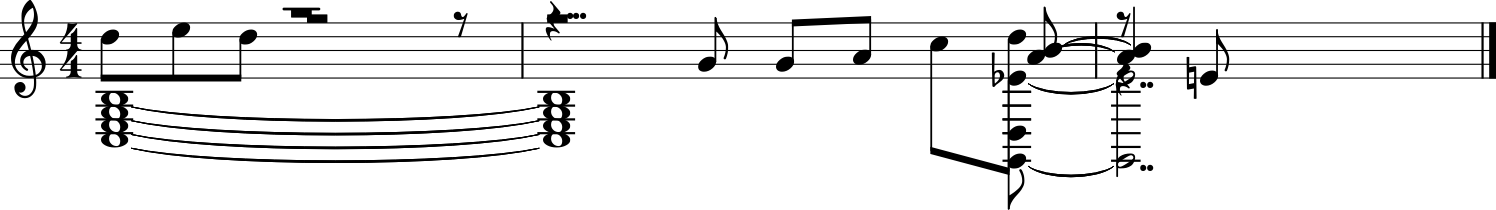

In [29]:
next_word = nw_predict_from_midi(learn, midi_file, n_words=20, seed_len=8); next_word.show()

Non midi note detected. Only returning valid portion. Index, seed 15 (25, 2)


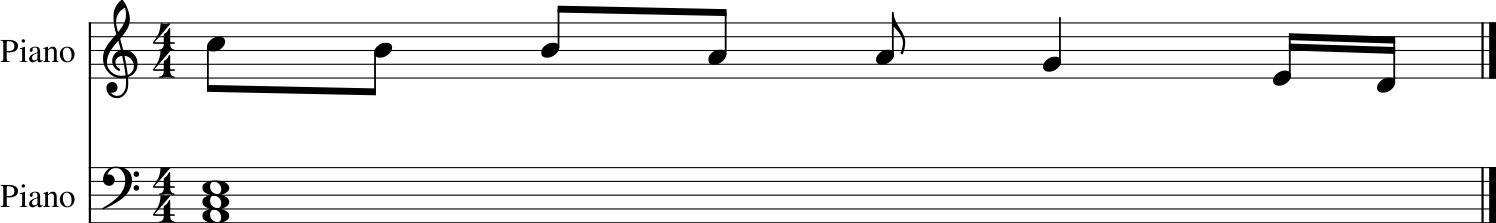

In [31]:
pred_melody = s2s_predict_from_midi(learn, midi_file, n_words=20, seed_len=4, pred_melody=True); pred_melody.show()

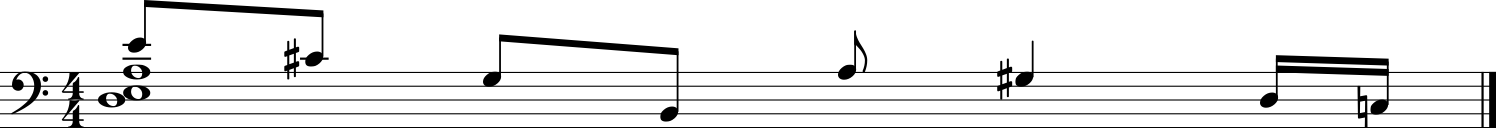

In [30]:
pred_notes = mask_predict_from_midi(learn, midi_file, predict_notes=True); pred_notes.show()